# FigureS11

### Import packages

In [1]:
%load_ext nb_black

import scdiffeq as sdq
import scdiffeq_analyses as sdq_an
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import cellplots as cp
import scipy.stats
import tqdm.notebook
import glob
import seaborn as sns
import ABCParse
import matplotlib.cm as cm
import cell_perturb
import scipy.stats
import sklearn
import pathlib
import torch
import larry
import matplotlib.cm as cm
import statsmodels.stats.meta_analysis
from scipy.stats import combine_pvalues
import pathlib

from typing import Union, Dict, List

<IPython.core.display.Javascript object>

### Load data

In [2]:
cmap = larry.pl.InVitroColorMap()._dict

h5ad_path = (
    "/home/mvinyard/data/adata.reprocessed_19OCT2023.more_feature_inclusive.h5ad"
)
adata = sdq.io.read_h5ad(h5ad_path)

AnnData object with n_obs × n_vars = 130887 × 2492
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone_idx', 'fate_observed', 't0_fated', 'train'
    var: 'gene_ids', 'hv_gene', 'must_include', 'exclude', 'use_genes'
    uns: 'fate_counts', 'h5ad_path', 'time_occupance'
    obsm: 'X_clone', 'X_pca', 'X_umap', 'cell_fate_df'
    layers: 'X_scaled'


<IPython.core.display.Javascript object>

### Define helper functions

In [3]:
def combine_expand(pvals):
    stat, combined_pval = combine_pvalues(pvals, method="fisher")
    return {"stat": stat, "combined_pval": combined_pval}


def prepare_stat_df_for_plotting(stats):

    stats["x"] = stats["pooled_mean_lfc_re"]
    stats["y"] = stats["combined_pval"].apply(np.log10) * -1
    stats["significant"] = stats["combined_pval"] < 0.05
    stats["insignificant"] = stats["combined_pval"] >= 0.05
    stats["pos"] = stats["pooled_mean_lfc_re"] > 0
    stats["neg"] = stats["pooled_mean_lfc_re"] <= 0

    stats["sig.pos"] = stats["significant"] & stats["pos"]
    stats["sig.neg"] = stats["significant"] & stats["neg"]
    stats["insig.pos"] = stats["insignificant"] & stats["pos"]
    stats["insig.neg"] = stats["insignificant"] & stats["neg"]

    assert not any(stats[["sig.pos", "sig.neg", "insig.pos", "insig.neg"]].sum(1) > 1)
    stats["group"] = stats[["sig.pos", "sig.neg", "insig.pos", "insig.neg"]].idxmax(1)

    return stats


def plot(stats, xlim=(None, None), ylim=(-2, None)):
    fig, axes = cp.plot(
        1,
        1,
        height=0.5,
        width=0.5,
        delete=[["top", "right"]],
        title=[
            ""
        ],  # LARRY Neutrophil Fate Perturbation Screen (N=5, z=10)"],  # Meta (5 models):
    )
    for group, group_df in stats.groupby("group"):
        if "insig" in group:
            c = "lightgrey"
        elif "pos" in group:
            c = "crimson"
        elif "neg" in group:
            c = "navy"
        axes[0].scatter(
            group_df["x"],
            group_df["y"],
            s=5,
            ec="None",
            c=c,
            rasterized=True,
            alpha=0.2,
        )
    axes[0].grid(True, alpha=0.2)
    axes[0].set_xlim(xlim)
    axes[0].set_ylim(ylim)
    neg_highlight = stats[stats["sig.neg"]].sort_values("y").tail(15)
    for i, row in neg_highlight.iterrows():
        axes[0].scatter(row["x"], row["y"], s=15, c="navy", ec="None", rasterized=True)
        axes[0].text(
            x=row["x"] * 1.1,
            y=row["y"] * 1.02,
            s=row.name,
            color="navy",
            ha="right",
            fontsize=6,
        )

    neg_highlight = stats[stats["sig.pos"]].sort_values("y").tail(15)
    for i, row in neg_highlight.iterrows():
        axes[0].scatter(
            row["x"], row["y"], s=15, c="crimson", ec="None", rasterized=True
        )
        axes[0].text(
            x=row["x"] * 1.1, y=row["y"] * 1.02, s=row.name, color="crimson", fontsize=6
        )
    axes[0].hlines(y=-np.log10(0.05), xmin=-2, xmax=2, color="k", ls="--", lw=1)

    # plt.savefig("LARRY.neu_screen.meta_analysis.svg", dpi=500)


def compute_lfc(ctrl, prtb, constant: float = 1e-9):
    return (prtb + constant).div((ctrl + constant)).apply(np.log2)


def compute_pval(ctrl, prtb, fates):
    return pd.Series(
        {
            fate: scipy.stats.ttest_ind(
                ctrl[_fates].sum(1), prtb[_fates].sum(1), equal_var=False
            )[1]
            for fate, _fates in fates.items()
        }
    )


def augment(df, all_fates):
    for col in all_fates:
        if not col in df:
            df[col] = 0
    return df


def augment_fate_dfs(perturbation_experiment, all_fates):

    ctrl = augment(perturbation_experiment.ctrl.T, all_fates=all_fates)
    prtb = augment(perturbation_experiment.prtb.T, all_fates=all_fates)

    return ctrl, prtb


def compute_lfc_grouped_fate(ctrl, prtb, fates: List):
    lfc = compute_lfc(ctrl[fates].sum(1), prtb[fates].sum(1))
    return lfc.mean(), lfc.std()


def compute_grouped_stats(perturbation_experiment, fate_groups: Dict):

    all_fates = fate_groups["MEP"] + fate_groups["GMP"]

    ctrl, prtb = augment_fate_dfs(perturbation_experiment, all_fates=all_fates)

    LFCStatDict_mean = {}
    LFCStatDict_std = {}
    for fate_group, fates in fate_groups.items():
        lfc, lfc_std = compute_lfc_grouped_fate(ctrl, prtb, fates=fates)
        LFCStatDict_mean[fate_group] = lfc
        LFCStatDict_std[fate_group] = lfc_std
    lfc = pd.Series(LFCStatDict_mean)
    lfc_std = pd.Series(LFCStatDict_std)

    pvals = compute_pval(ctrl, prtb, fates=fate_groups)
    stats = pd.DataFrame([pvals, lfc, lfc_std]).T.rename(
        {0: "pval", 1: "lfc", 2: "lfc_std"}, axis=1
    )
    return stats


class RawScreenProcessor(ABCParse.ABCParse):
    """Processed pkl to .csv"""

    def __init__(self, results_dir: Union[pathlib.Path, str], *args, **kwargs):
        self.__parse__(locals())

        self._initialize_directory_structure()

    @property
    def results_dir(self):
        return pathlib.Path(self._results_dir)

    @property
    def pkl_dir(self):
        return self.results_dir.joinpath("pkl")

    @property
    def csv_dir(self):
        return self.results_dir.joinpath("csv")

    def _initialize_directory_structure(self):
        """/pkl/ subdir should already exist, so we shouldn't create it here."""
        if not self.csv_dir.exists():
            self.csv_dir.mkdir()

    @property
    def _discovered_csv_paths(self):
        return sorted(list(self.csv_dir.glob("*.csv")))

    @property
    def pkl_paths(self):
        return sorted(list(self.pkl_dir.glob("*.pkl")))

    #     def _process_attribute(self, file, key):
    #         return (
    #             pd.DataFrame({gene: result.stats[key] for gene, result in file.items()})
    #             .fillna(0)
    #             .T
    #         )

    def _preprocess_grouped_fates_file(self, screen_file):

        fates = {"MEP": ["Meg", "Ery"], "GMP": ["Mon", "Neu", "Bas"]}

        Stats = {}
        for gene, expt in tqdm.notebook.tqdm(screen_file.items()):
            Stats[gene] = compute_grouped_stats(expt, fates)

        MEP = (
            pd.DataFrame({gene: stat.loc["MEP"] for gene, stat in Stats.items()})
            .T.reset_index()
            .rename({"index": "gene"}, axis=1)
        )
        GMP = (
            pd.DataFrame({gene: stat.loc["GMP"] for gene, stat in Stats.items()})
            .T.reset_index()
            .rename({"index": "gene"}, axis=1)
        )
        results = {"MEP": MEP, "GMP": GMP}
        return results

    def _get_n(self, file, gene):
        return np.unique([file[gene].ctrl.shape[1], file[gene].prtb.shape[1]])[0]

    def _read_and_process_raw_pkl_files(self):

        fpath = pathlib.Path("./v3_screen_results.human_hematopoiesis/preprocessed.pkl")

        if fpath.exists():
            ScreenResults = sdq.io.read_pickle(fpath)
        else:
            ScreenResults = {}
            attr_cols = ["lfc", "lfc_std", "pval"]
            for pkl_path in self.pkl_paths:
                version = pkl_path.name.split("version_")[-1].split(".")[0]
                version = f"version_{version}"
                file = sdq.io.read_pickle(pkl_path)
                ScreenResults[version] = self._preprocess_grouped_fates_file(file)
                sdq.io.write_pickle(
                    ScreenResults,
                    "./v3_screen_results.human_hematopoiesis/preprocessed.pkl",
                )
        return ScreenResults

    def __call__(self, *args, **kwargs):
        self.__update__(locals())

        return self._read_and_process_raw_pkl_files()


def process_raw_results(results_dir: str):
    raw_screen_processor = RawScreenProcessor(results_dir=results_dir)
    return raw_screen_processor()


def aggr_fate_statistics(results, fate):
    _aggr_fate_frames = []
    for version, frame in results.items():
        fate_version_frame = (
            frame["lfc"][fate]
            .to_frame()
            .reset_index()
            .rename({"index": "gene", fate: "lfc"}, axis=1)
        )
        fate_version_frame["model"] = version
        fate_version_frame["pval"] = frame["pval"][fate].values
        fate_version_frame["se"] = (
            frame["lfc_std"][fate].div(np.sqrt(frame["lfc_std"]["n"])).values
        )
        _aggr_fate_frames.append(fate_version_frame)

    return pd.concat(_aggr_fate_frames)


def adjust_negative_i2(meta_results_df):
    i2 = np.zeros(len(meta_results_df))
    mask = meta_results_df["i2"] > 0
    pos_i2 = meta_results_df.loc[mask]["i2"].values
    i2[mask] = pos_i2
    meta_results_df["i2"] = i2


def run_meta_analysis(aggr_stats):
    meta_analysis_results = []
    for gene in aggr_stats["gene"].unique():
        gene_df = aggr_stats.loc[aggr_stats["gene"] == gene]
        effect = gene_df["lfc"].values
        variance = (gene_df["se"] ** 2).values
        res_re = statsmodels.stats.meta_analysis.combine_effects(
            effect=effect, variance=variance, method_re="iterated"
        )
        conf_int = np.array(res_re.conf_int())
        ci_low, ci_high = conf_int[:, 0], conf_int[:, 1]

        meta_analysis_results.append(
            {
                "gene": gene,
                "pooled_mean_lfc_re": res_re.mean_effect_re,
                "ci_low": ci_low[0],  # Accessing the first element for CI
                "ci_high": ci_high[0],  # Accessing the first element for CI
                "i2": res_re.i2,
                "q": res_re.q,
            }
        )

    meta_results_df = pd.DataFrame(meta_analysis_results).set_index("gene")
    adjust_negative_i2(meta_results_df)

    return meta_results_df


def combine_expand(pvals):
    stat, combined_pval = combine_pvalues(pvals, method="fisher")
    return {"stat": stat, "combined_pval": combined_pval}


def prepare_stat_df_for_plotting(stats):

    stats["x"] = stats["pooled_mean_lfc_re"]
    stats["y"] = stats["combined_pval"].apply(np.log10) * -1
    stats["significant"] = stats["combined_pval"] < 0.05
    stats["insignificant"] = stats["combined_pval"] >= 0.05
    stats["pos"] = stats["pooled_mean_lfc_re"] > 0
    stats["neg"] = stats["pooled_mean_lfc_re"] <= 0

    stats["sig.pos"] = stats["significant"] & stats["pos"]
    stats["sig.neg"] = stats["significant"] & stats["neg"]
    stats["insig.pos"] = stats["insignificant"] & stats["pos"]
    stats["insig.neg"] = stats["insignificant"] & stats["neg"]

    assert not any(stats[["sig.pos", "sig.neg", "insig.pos", "insig.neg"]].sum(1) > 1)
    stats["group"] = stats[["sig.pos", "sig.neg", "insig.pos", "insig.neg"]].idxmax(1)

    return stats


def plot_volcano(
    stats, xlim=(None, None), ylim=(-2, None), savepath=None, highlight_genes=[]
):
    fig, axes = cp.plot(
        1,
        1,
        height=2,
        width=2,
        delete=[["top", "right"]],
        title=[
            ""
        ],  # LARRY Neutrophil Fate Perturbation Screen (N=5, z=10)"],  # Meta (5 models):
    )
    for group, group_df in stats.groupby("group"):
        if "insig" in group:
            c = "lightgrey"
        elif "pos" in group:
            c = "crimson"
        elif "neg" in group:
            c = "navy"
        axes[0].scatter(
            group_df["x"],
            group_df["y"],
            s=5,
            ec="None",
            c=c,
            rasterized=True,
            alpha=0.2,
        )
    axes[0].grid(True, alpha=0.2)
    axes[0].set_xlim(xlim)
    axes[0].set_ylim(ylim)

    stats_highlight = stats.loc[highlight_genes].copy()

    neg_highlight = stats_highlight[stats_highlight["sig.neg"]]
    for i, row in neg_highlight.iterrows():
        axes[0].scatter(row["x"], row["y"], s=25, c="w", ec="None", rasterized=False)
        axes[0].scatter(row["x"], row["y"], s=15, c="navy", ec="None", rasterized=False)
        axes[0].text(
            x=row["x"],
            y=row["y"],
            s=row.name,
            color="navy",
            ha="right",
            fontsize=6,
        )

    pos_highlight = stats_highlight[stats_highlight["sig.pos"]]
    for i, row in pos_highlight.iterrows():
        axes[0].scatter(row["x"], row["y"], s=25, c="w", ec="None", rasterized=False)
        axes[0].scatter(
            row["x"], row["y"], s=15, c="crimson", ec="None", rasterized=False
        )
        axes[0].text(x=row["x"], y=row["y"], s=row.name, color="crimson", fontsize=6)
    axes[0].hlines(
        y=-np.log10(0.05), xmin=xlim[0], xmax=xlim[1], color="k", ls="--", lw=1
    )

    if savepath:
        plt.savefig(savepath, dpi=500)


class MetaAnalysis(ABCParse.ABCParse):
    def __init__(
        self,
        results_dir: str = "./v3_screen_results.human_hematopoiesis",
        *args,
        **kwargs,
    ):
        self.__parse__(locals())

        self.results = process_raw_results(self.results_dir)

    def revised_aggr_fate_statistics(self, results, fate):

        _aggr_fate_frames = []
        for version, result in results.items():
            frame = result[fate]
            frame["model"] = version
            frame["se"] = frame["lfc_std"].div(np.sqrt(10)).values
            _aggr_fate_frames.append(frame)
        aggr_fate_frames = (
            pd.concat(_aggr_fate_frames).reset_index().drop("index", axis=1)
        )

        return aggr_fate_frames

    @property
    def results_dir(self):
        results_dir = pathlib.Path(self._results_dir)
        if not results_dir.exists():
            results_dir.mkdir()
        return results_dir

    def _combine_pvals(self, aggr):
        return aggr.groupby("gene")["pval"].apply(combine_expand).unstack()

    @property
    def aggr(self):
        if not hasattr(self, "_attr"):
            self._attr = self.revised_aggr_fate_statistics(
                self.results, fate=self._fate
            )
        return self._attr

    def forward(self, fate):

        self._fate = fate

        meta = run_meta_analysis(self.aggr)
        combined_pvals = self._combine_pvals(self.aggr)
        stats = pd.concat(
            [
                meta["pooled_mean_lfc_re"],
                combined_pvals["combined_pval"],
            ],
            axis=1,
        )
        return prepare_stat_df_for_plotting(stats)

<IPython.core.display.Javascript object>

### Run meta-analysis

In [4]:
meta_analysis = MetaAnalysis()
mep = meta_analysis.forward(fate="MEP")

<IPython.core.display.Javascript object>

In [5]:
meta_analysis = MetaAnalysis()
gmp = meta_analysis.forward(fate="GMP")

<IPython.core.display.Javascript object>

### Compute correlation

In [7]:
MEPCrossCorr = {}
GMPCrossCorr = {}
for version_i, results_i in meta_analysis.results.items():
    MEPCrossCorr[version_i] = {}
    GMPCrossCorr[version_i] = {}
    for version_j, results_j in meta_analysis.results.items():
        mep_lfc_i = results_i["MEP"]["lfc"]
        mep_lfc_j = results_j["MEP"]["lfc"]
        gmp_lfc_i = results_i["GMP"]["lfc"]
        gmp_lfc_j = results_j["GMP"]["lfc"]

        mep_corr = scipy.stats.pearsonr(mep_lfc_i, mep_lfc_j)[0]
        gmp_corr = scipy.stats.pearsonr(gmp_lfc_i, gmp_lfc_j)[0]
        MEPCrossCorr[version_i][version_j] = mep_corr
        GMPCrossCorr[version_i][version_j] = gmp_corr

mep_corr = pd.DataFrame(MEPCrossCorr)
gmp_corr = pd.DataFrame(GMPCrossCorr)

<IPython.core.display.Javascript object>

### Plot correlation heatmaps

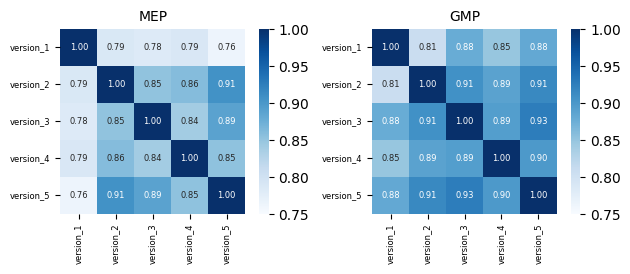

<IPython.core.display.Javascript object>

In [8]:
size = 0.5
fig, axes = cp.plot(
    2, 2, wspace=0.1, height=1 * size, width=1.2 * size, title=["MEP", "GMP"]
)
axes[0] = sns.heatmap(
    mep_corr,
    cmap="Blues",
    annot=True,
    annot_kws={"fontsize": 6},
    ax=axes[0],
    vmin=0.75,
    vmax=1,
    square=True,
    fmt=".2f",
)
axes[1] = sns.heatmap(
    gmp_corr,
    cmap="Blues",
    annot=True,
    annot_kws={"fontsize": 6},
    ax=axes[1],
    vmin=0.75,
    vmax=1,
    square=True,
    fmt=".2f",
)
plt.savefig("MEP_GMP.cross_replicate_correlation.svg")